# Testing bias metrics and mitigation algorithms on the Compas dataset

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from aif360.datasets import CompasDataset
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from matplotlib.gridspec import GridSpec
from utility import *
from Sampler import Sampler
import os

path = 'imgs/compas'

## Dataset Description

COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is a popular commercial algorithm used by judges and parole officers for scoring criminal defendant’s likelihood of reoffending (recidivism). It has been shown that the algorithm is biased in favor of white defendants, and against black inmates, based on a 2 year follow up study (i.e who actually committed crimes or violent crimes after 2 years). The pattern of mistakes, as measured by precision/sensitivity is notable.

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the unsensitive variables at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the unsensitive attributes are changed s.t. the correlation between the variables and the sensitive attribute _S_ is removed while keeping the ranking of the items for the classifier.
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier. 

3. **Sampling**

> Sampling is a modified version of the Reweighing algorithm. First of all, it considered the groups made by each combinantion of the values of sensitive variables and labels. Then, for each group it computes his disparity ($\frac{size\_exp}{size\_obs}$) and samples each group untill this value becomes 1. The final dataset will be a dataset in which each group is balanced.

# Importing and exploring the dataset

In [7]:
compas = CompasDataset(features_to_drop=['age_cat'])

In [47]:
compas.features.shape

(6167, 398)

In [48]:
compas.protected_attribute_names

['sex', 'race']

In [49]:
compas.metadata['protected_attribute_maps']

[{0.0: 'Male', 1.0: 'Female'}, {1.0: 'Caucasian', 0.0: 'Not Caucasian'}]

In [50]:
compas.label_names

['two_year_recid']

In [51]:
compas.favorable_label

0.0

In [3]:
compas_df = compas.convert_to_dataframe()[0]

In [4]:
compas_df

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree=F,c_charge_degree=M,c_charge_desc=Abuse Without Great Harm,...,c_charge_desc=Viol Injunct Domestic Violence,c_charge_desc=Viol Injunction Protect Dom Vi,c_charge_desc=Viol Pretrial Release Dom Viol,c_charge_desc=Viol Prot Injunc Repeat Viol,c_charge_desc=Violation License Restrictions,c_charge_desc=Violation Of Boater Safety Id,c_charge_desc=Violation of Injunction Order/Stalking/Cyberstalking,c_charge_desc=Voyeurism,c_charge_desc=arrest case no charge,two_year_recid
1,0.0,69.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,34.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,24.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,41.0,1.0,0.0,0.0,0.0,14.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10996,0.0,23.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10997,0.0,23.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10999,0.0,57.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11000,1.0,33.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


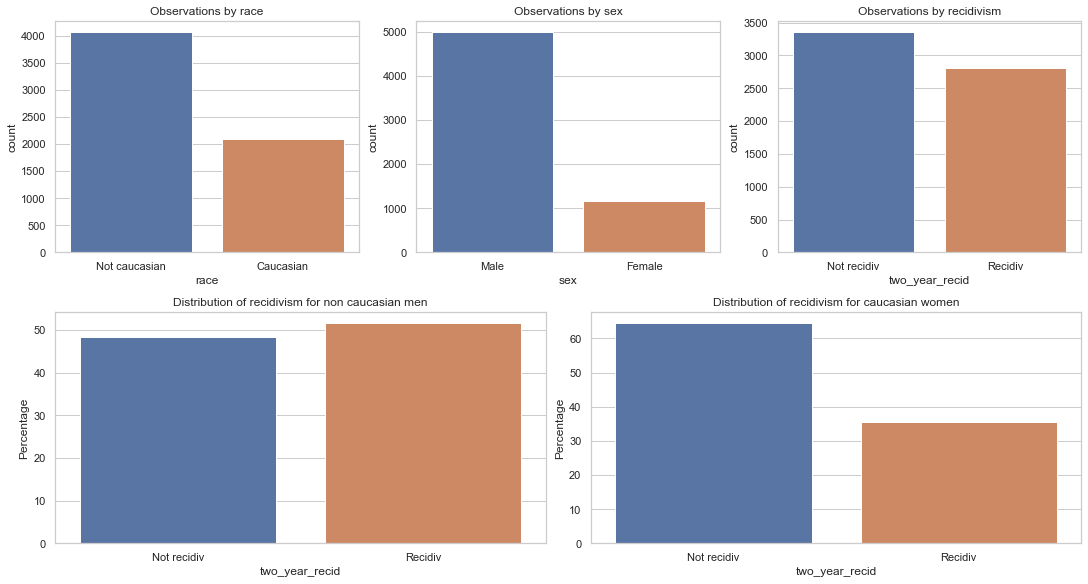

In [54]:
fig = plt.figure(constrained_layout=True, figsize=(15,8))
gs = GridSpec(2, 6, figure=fig)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:])
ax4 = fig.add_subplot(gs[1, 0:3])
ax5 = fig.add_subplot(gs[1, 3:6])
sns.countplot(x='race', data=compas_df, ax=ax1)
ax1.set_title('Observations by race')
ax1.set_xticklabels(['Not caucasian', 'Caucasian'])
sns.countplot(x='sex', data=compas_df, ax=ax2)
ax2.set_xticklabels(['Male', 'Female'])
ax2.set_title('Observations by sex')
sns.countplot(x='two_year_recid', data=compas_df, ax=ax3)
ax3.set_xticklabels(['Not recidiv', 'Recidiv'])
ax3.set_title('Observations by recidivism')
perc = (compas_df[['sex','race','two_year_recid']]
        .groupby(['sex','race'])['two_year_recid']
        .value_counts(normalize=True)
        .mul(100).rename('Percentage')
        .reset_index()
       )
sns.barplot(data=perc[(perc['sex']==0)&(perc['race']==0)], x='two_year_recid', y='Percentage', ax=ax4)
ax4.set_xticklabels(['Not recidiv', 'Recidiv'])
ax4.set_title('Distribution of recidivism for non caucasian men')
sns.barplot(data=perc[(perc['sex']==1)&(perc['race']==1)], x='two_year_recid', y='Percentage', ax=ax5)
ax5.set_xticklabels(['Not recidiv', 'Recidiv'])
ax5.set_title('Distribution of recidivism for caucasian women')
#fig.suptitle("Distribution of credit risk by sensitive groups")
plt.savefig(os.path.join(path, 'compas_counts.pdf'))
plt.show()

So we are in a **Balanced bias dataset** case

# Bias dataset and classification metrics

In [8]:
privileged_group = [{'sex':1, 'race':1}]
unprivileged_group = [{'sex':0, 'race':0}]

## Bias dataset case

### Dataset Metrics:

Disparate Impact: 0.7481
Statistical Parity: -0.1627




### Classification Metrics:

Balanced accuracy: 0.6645
Statistical parity: -0.3952
Disparate impact: 0.5204
Average odds: -0.3629
Equal opportunity: -0.2986
Theil index: 0.2326


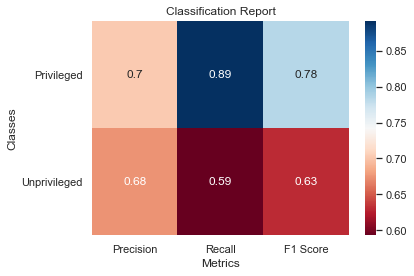

In [56]:
class_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    compas, privileged_group, unprivileged_group)

## Reweighing

In [57]:
rw_data = compas.copy()
rw = Reweighing(unprivileged_group, privileged_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.6499
Statistical parity: -0.1647
Disparate impact: 0.7807
Average odds: -0.1268
Equal opportunity: -0.0747
Theil index: 0.2101


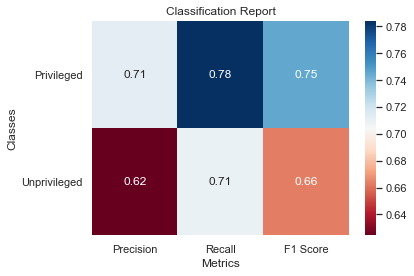

In [58]:
rw_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_data, privileged_group, unprivileged_group, debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


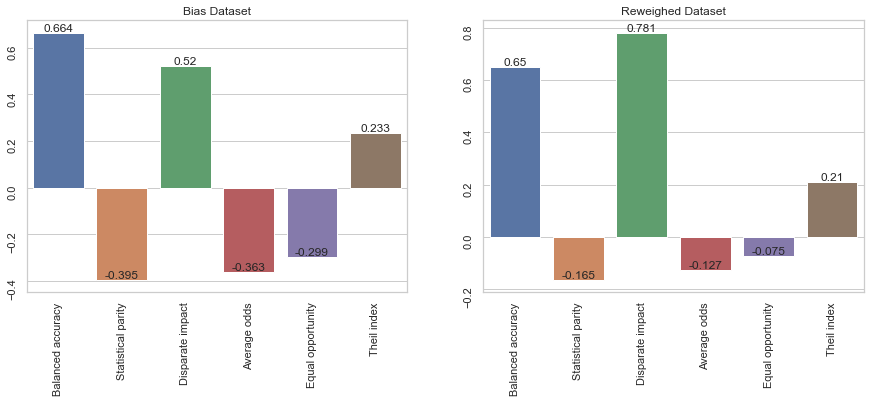

In [59]:
plot_metrics_comparison(class_metrics, rw_class, "Bias Dataset", "Reweighed Dataset")
plt.show()

## Disparate Impact

Since we have two sensitive attributes, DIR requires to create an attribute that is the joint probability distribution of the two sensitive attributes and to transform the unsensitive variables with respect to this new variable:

In [19]:
dir_data = compas.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)

In [20]:
df = dir_data.convert_to_dataframe()[0]
probs = (
    df.value_counts(["sex", "race"], normalize=True).unstack().reset_index()
    .melt(id_vars='sex', value_vars=[0.0,1.0], var_name='race', value_name='probs'))

In [21]:
for sex,race,prob in probs.values:
    df.loc[(df['sex'] == sex) & (df['race'] == race), 'prob'] = prob

In [12]:
df.drop(df[['sex','race']], axis=1, inplace=True)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


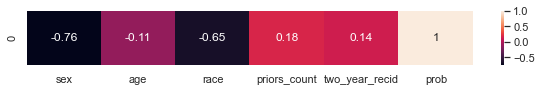

In [22]:
corr = df.corrwith(df['prob'], drop=True)
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr[(abs(corr[0])>0.1)].T, annot=True)
plt.show()

In [23]:
probs

,sex,race,probs
0,0.0,0.0,0.547106
1,1.0,0.0,0.112372
2,0.0,1.0,0.262689
3,1.0,1.0,0.077834


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


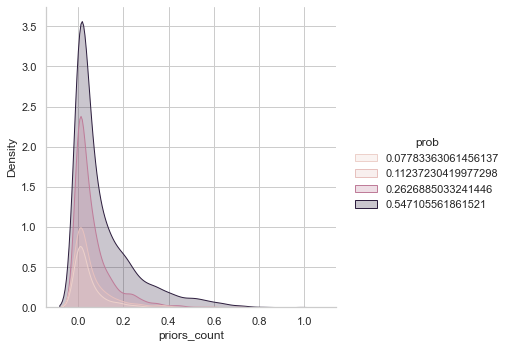

In [24]:
sns.displot(data=df, x='priors_count', hue='prob', kind='kde', multiple='layer', fill=True)
plt.show()

In [25]:
di = DisparateImpactRemover(sensitive_attribute='prob')
dir_data = BinaryLabelDataset(df=df, label_names=['two_year_recid'], protected_attribute_names=['prob'])
dir_data = di.fit_transform(dir_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


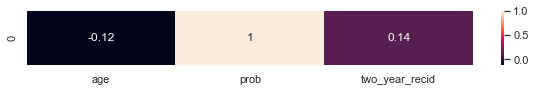

In [26]:
df_dir = dir_data.convert_to_dataframe()[0]
corr = df_dir.corrwith(df['prob'], drop=True)
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr[(abs(corr[0])>0.1)].T, annot=True)
plt.show()

In [18]:
df_dir

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree=F,c_charge_degree=M,c_charge_desc=Abuse Without Great Harm,c_charge_desc=Agg Abuse Elderlly/Disabled Adult,c_charge_desc=Agg Assault W/int Com Fel Dome,...,c_charge_desc=Viol Injunction Protect Dom Vi,c_charge_desc=Viol Pretrial Release Dom Viol,c_charge_desc=Viol Prot Injunc Repeat Viol,c_charge_desc=Violation License Restrictions,c_charge_desc=Violation Of Boater Safety Id,c_charge_desc=Violation of Injunction Order/Stalking/Cyberstalking,c_charge_desc=Voyeurism,c_charge_desc=arrest case no charge,prob,two_year_recid
1,0.628205,0.05,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.547106,0.0
3,0.205128,0.05,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.547106,1.0
4,0.076923,0.05,0.0,0.0,0.078947,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.547106,1.0
7,0.307692,0.05,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.547106,0.0
8,0.256410,0.05,0.0,0.0,0.289474,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.262689,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10996,0.064103,0.05,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.547106,0.0
10997,0.064103,0.05,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.547106,0.0
10999,0.461538,0.05,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.547106,0.0
11000,0.192308,0.05,0.0,0.0,0.078947,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.112372,0.0


In [27]:
df.loc[df['prob'].round(6) == 0.077834, 'prob'] = 1
df.loc[df['prob'].round(6) != 1, 'prob'] = 0

df_dir.loc[df_dir['prob'].round(6) == 0.077834, 'prob'] = 1
df_dir.loc[df_dir['prob'].round(6) != 1, 'prob'] = 0

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


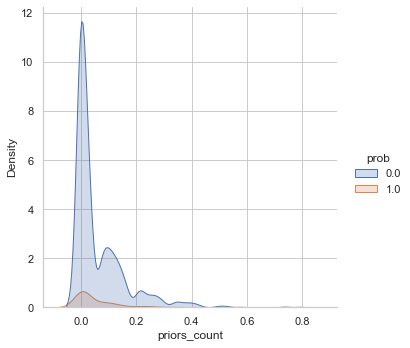

In [28]:
sns.displot(data=df_dir, x='priors_count', hue='prob', kind='kde', multiple='layer', fill=True)
plt.show()

In [29]:
prob_priv_group = [{'prob': 1}]
prob_unpriv_group = [{'prob': 0}]

In [30]:
dir_data = BinaryLabelDataset(df=df_dir, label_names=['two_year_recid'], protected_attribute_names=['prob'])

### Dataset Metrics:

Disparate Impact: 1.3110
Statistical Parity: 0.1099




### Classification Metrics:

Balanced accuracy: 0.6586
Statistical parity: 0.1110
Disparate impact: 1.3208
Average odds: 0.0642
Equal opportunity: 0.0362
Theil index: 0.2268


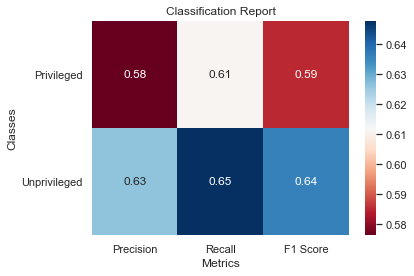

In [31]:
dir_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    dir_data, priv_group = prob_priv_group, unpriv_group = prob_unpriv_group, sensitive_attributes=['prob'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


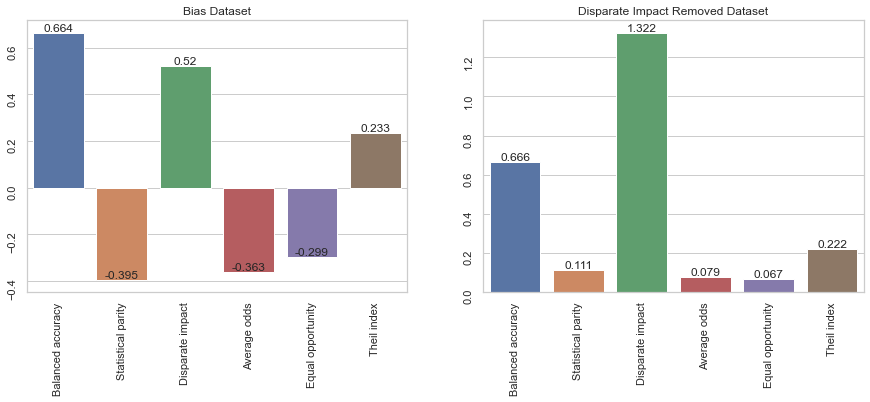

In [74]:
plot_metrics_comparison(class_metrics, dir_class, 'Bias Dataset', 'Disparate Impact Removed Dataset')
plt.show()

## Sampling prob

In [75]:
sampled_prob = BinaryLabelDataset(df=df, label_names=['two_year_recid'], protected_attribute_names=['prob'], 
                                  favorable_label=0.0, unfavorable_label=1.0)
sampler = Sampler(round_level=1)

### Dataset Metrics:

Disparate Impact: 1.0748
Statistical Parity: 0.0323




### Classification Metrics:

Balanced accuracy: 0.6636
Statistical parity: -0.0876
Disparate impact: 0.8632
Average odds: -0.0586
Equal opportunity: -0.0330
Theil index: 0.2331


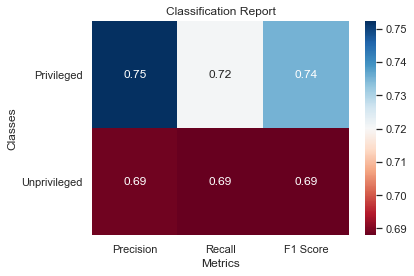

In [76]:
sampled_prob_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled_prob, prob_priv_group, prob_unpriv_group, debiaser=sampler, n_splits=5
)

## Modified Reweighing (Sampling)

In [77]:
sampled_data = compas.copy()
sampler = Sampler(round_level=2)

### Dataset Metrics:

Disparate Impact: 1.0080
Statistical Parity: 0.0036




### Classification Metrics:

Balanced accuracy: 0.6549
Statistical parity: -0.0034
Disparate impact: 0.9950
Average odds: 0.0477
Equal opportunity: 0.0538
Theil index: 0.2425


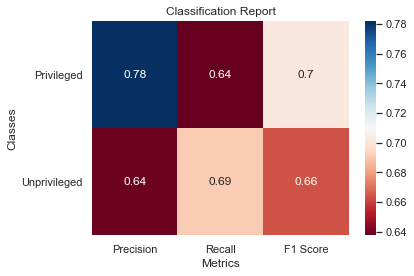

In [78]:
sampled_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    sampled_data, privileged_group, unprivileged_group, debiaser=sampler, n_splits=5)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


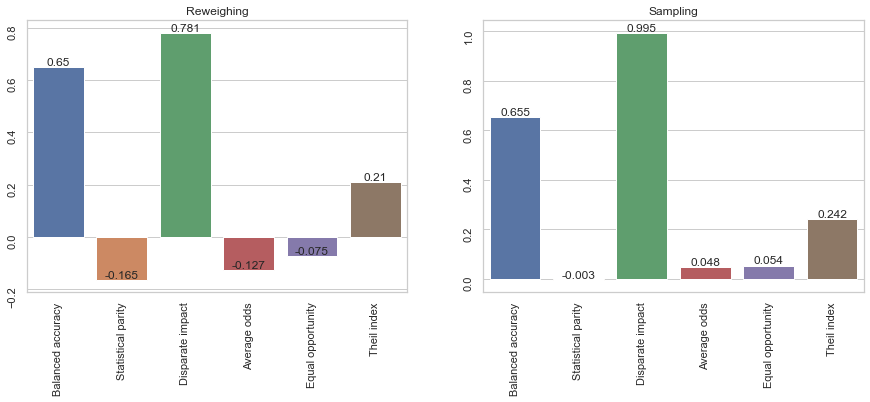

In [79]:
plot_metrics_comparison(rw_class, sampled_metrics, 'Reweighing', 'Sampling')
plt.show()

## Reweighing + DIR

In [80]:
rw_dir_data = dir_data.copy()
rw = Reweighing(prob_unpriv_group, prob_priv_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.6624
Statistical parity: 0.1030
Disparate impact: 1.3264
Average odds: 0.0625
Equal opportunity: 0.0408
Theil index: 0.2261


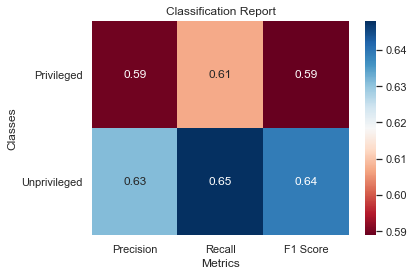

In [81]:
rw_dir_score = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_dir_data, priv_group=prob_priv_group, unpriv_group=prob_unpriv_group, sensitive_attributes=rw_dir_data.protected_attribute_names, debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


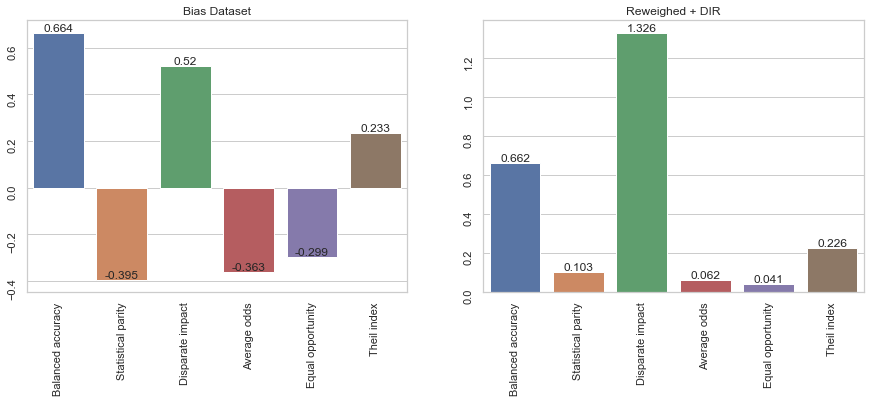

In [82]:
plot_metrics_comparison(class_metrics, rw_dir_score, 'Bias Dataset', 'Reweighed + DIR')
plt.show()

## Algorithms Comparison

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias Dataset,-0.3629,0.6645,0.5204,-0.2986,-0.3952,0.2326
Classic sampling with flag variable,-0.0586,0.6636,0.8632,-0.0330,-0.0876,0.2331
DEMV,0.0477,0.6549,0.9950,0.0538,-0.0034,0.2425
Disparate Impact Remover,0.0794,0.6658,1.3223,0.0667,0.1113,0.2216
Reweighing,-0.1268,0.6499,0.7807,-0.0747,-0.1647,0.2101
Reweighing + DIR,0.0625,0.6624,1.3264,0.0408,0.1030,0.2261


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


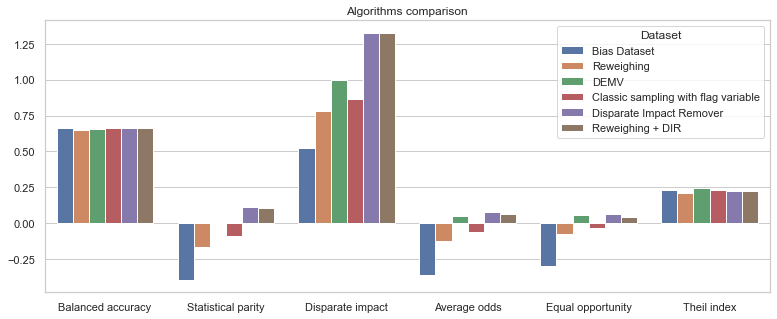

In [83]:
plot_syntesis(merge_datasets({
    'Bias Dataset': class_metrics,
    'Reweighing': rw_class,
    'DEMV': sampled_metrics,
    'Classic sampling with flag variable': sampled_prob_metrics,
    'Disparate Impact Remover': dir_class,
    'Reweighing + DIR': rw_dir_score
}), 'Algorithms comparison')
plt.savefig(os.path.join(path, 'compas_syn.pdf'))
plt.show()